In [1]:
pip install scikit-learn==1.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 30.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
# Importation des bibliothèques nécessaires
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Charger les données
concatenated_df = pd.read_csv('/content/drive/My Drive/preprocessed_df.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import re

def remove_emoji(string):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string)


def clean_tweet(tweet):
    if type(tweet) == float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#","", temp)
    temp = remove_emoji(temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)

    return temp
concatenated_df['review_body'] = concatenated_df['review_body'].map(lambda x : clean_tweet(x))

In [5]:
# Supprimer les valeurs nulles
concatenated_df = concatenated_df.dropna(subset=['review_body', 'review_body_sentiment_label'])


In [6]:
# Convertir les étiquettes de classe en entiers
# Encoder les étiquettes
label_encoder = LabelEncoder()
concatenated_df ['review_body_sentiment_label'] = label_encoder.fit_transform(concatenated_df ['review_body_sentiment_label'])


In [7]:
# Diviser les données en ensemble d'entraînement et ensemble de test
X = concatenated_df['review_body']
y = concatenated_df['review_body_sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Vectoriser les textes
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [8]:
from sklearn.svm import LinearSVC
# Initialiser le modèle
clf = LinearSVC(random_state=42)

# Entraîner le modèle
clf.fit(X_train_vect, y_train)

LinearSVC(random_state=42)

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, classification_report, matthews_corrcoef, roc_curve, auc

# Obtenir les prédictions du modèle sur les données de test
y_pred = clf.predict(X_test_vect)

# Calcul des probabilités prédites pour la courbe ROC-AUC (si applicable)
if hasattr(clf, 'predict_proba'):
    y_pred_proba = clf.predict_proba(X_test_vect)
else:
    y_pred_proba = None

# Évaluation des performances
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Utilisation de 'weighted' pour les classes déséquilibrées
from sklearn.preprocessing import label_binarize

# Calculer la ROC-AUC
if y_pred_proba is not None:
    if y_pred_proba.shape[1] == 2:  # Cas binaire
        y_test_binarized = label_binarize(y_test, classes=[0, 1])
        roc_auc = roc_auc_score(y_test_binarized, y_pred_proba[:, 1])
    else:  # Cas multi-classes
        y_test_binarized = label_binarize(y_test, classes=np.arange(len(np.unique(y_test))))
        roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
else:
    roc_auc = 'N/A'
mcc = matthews_corrcoef(y_test, y_pred)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy)
print("Precision:", precision)
print("ROC-AUC:", roc_auc)
print("MCC:", mcc)


              precision    recall  f1-score   support

           0       0.83      0.85      0.84     18851
           1       0.83      0.80      0.81     10399
           2       0.88      0.87      0.87     20750

    accuracy                           0.85     50000
   macro avg       0.84      0.84      0.84     50000
weighted avg       0.85      0.85      0.85     50000

Accuracy: 0.8466
Precision: 0.8467444501233561
ROC-AUC: N/A
MCC: 0.760877979569862


In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
# Définition des classificateurs individuels
clf1 = LogisticRegression(max_iter=1000, random_state=42)
clf2 = LinearSVC(random_state=42)
clf3 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

In [ ]:
clf2 = LinearSVC(random_state=42)

In [ ]:
from sklearn.ensemble import  VotingClassifier
from sklearn.pipeline import Pipeline
# Création du Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', clf1),
        ('svc', clf2),
        ('gb', clf3)
    ],
    voting='soft'  # Utilisation du vote par probabilité
)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# Définition du pipeline de traitement
pipeline = Pipeline([
    ('vect', CountVectorizer()),  # Convertir les textes en vecteurs de mots
    ('tfidf', TfidfTransformer()),  # Appliquer la transformation TF-IDF
    ('clf', voting_clf)  # Utiliser le Voting Classifier
])

# Entraînement du modèle
pipeline.fit(X_train, y_train)


In [22]:
# Faire des prédictions
#y_pred = pipeline.predict(X_test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Utiliser 'weighted' si c'est un problème de classification multiclasses
mcc = matthews_corrcoef(y_test, y_pred)

# Affichage des résultats
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy)
print("Precision:", precision)
print("MCC:", mcc)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84     18851
           1       0.86      0.81      0.83     10399
           2       0.89      0.87      0.88     20750

    accuracy                           0.85     50000
   macro avg       0.85      0.85      0.85     50000
weighted avg       0.86      0.85      0.85     50000

Accuracy: 0.85472
Precision: 0.8556309033810569
MCC: 0.7735505959918751


In [12]:
from sklearn.ensemble import  VotingClassifier
from sklearn.pipeline import Pipeline
# Création du Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', clf1),
        ('svc', clf2),
        ('gb', clf3)
    ],
    voting='hard'  # Utilisation du vote par probabilité
)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# Définition du pipeline de traitement
pipeline = Pipeline([
    ('vect', CountVectorizer()),  # Convertir les textes en vecteurs de mots
    ('tfidf', TfidfTransformer()),  # Appliquer la transformation TF-IDF
    ('clf', voting_clf)  # Utiliser le Voting Classifier
])

# Entraînement du modèle
pipeline.fit(X_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=42)),
                                              ('svc',
                                               LinearSVC(random_state=42)),
                                              ('gb',
                                               GradientBoostingClassifier(learning_rate=1.0,
                                                                          max_depth=1,
                                                                          random_state=42))]))])

In [16]:
# Faire des prédictions
y_pred = pipeline.predict(X_test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Utiliser 'weighted' si c'est un problème de classification multiclasses
mcc = matthews_corrcoef(y_test, y_pred)

# Affichage des résultats
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy)
print("Precision:", precision)
print("MCC:", mcc)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84     18851
           1       0.86      0.81      0.83     10399
           2       0.89      0.87      0.88     20750

    accuracy                           0.85     50000
   macro avg       0.85      0.85      0.85     50000
weighted avg       0.86      0.85      0.85     50000

Accuracy: 0.85472
Precision: 0.8556336137971348
MCC: 0.7735457362592317


In [17]:
import joblib
# Sauvegarde du pipeline dans un fichier .pkl
joblib.dump(pipeline, 'pipelinecorrecte.pkl')

['pipelinecorrecte.pkl']

In [18]:
# Charger le pipeline à partir du fichier .pkl
pipeline = joblib.load('pipelinecorrecte.pkl')


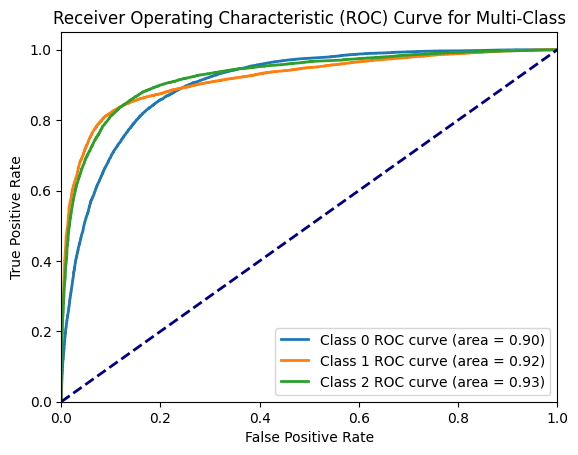

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binariser les étiquettes de test
y_test_binarized = label_binarize(y_test, classes=np.arange(len(np.unique(y_test))))

# Calcul des probabilités prédites pour la courbe ROC
if hasattr(clf, 'predict_proba'):
    y_pred_proba = clf.predict_proba(X_test_vect)
else:
    y_pred_proba = None

if y_pred_proba is not None:
    # Tracer les courbes ROC pour chaque classe
    plt.figure()
    for i in range(y_test_binarized.shape[1]):
        fpr, tpr, thresholds = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='Class %d ROC curve (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Le classifieur ne supporte pas predict_proba.")


In [ ]:
model.save('/content/modele_82.h5')

In [ ]:
from joblib import dump

# Enregistrement du modèle
dump(model, '/content/modele_82.h5')

['/content/modele_82.h5']

In [ ]:
import pickle

# Charger le modèle depuis le fichier .pkl
with open('/content/modele_85.pkl', 'rb') as f:
    model = pickle.load(f)


In [ ]:
max_words = 1000
max_len = 100